In [1]:
# Import the necessary classes
from uniswap_data import Uniswap_Pool
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, kurtosis, pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint
import requests

In [2]:
plt.style.use('panoptic-dark-16_9.mplstyle')

OSError: 'panoptic-dark-16_9.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [3]:
chosen_currency = 'ETH'

# Ethereum Network

In [18]:
# Parameters for the Uniswap pool
token_0 = 'USDC'  # Stablecoin for example
token_1 = 'ETH'   # Ethereum for example
fee = 30    # 5 bps fee or 1, 30 or 100 
start = '2023-07-01'  # Start in string
end = '2025-07-01'    # End in string
window = 60 * 60 * 24  # 1 day window
inverse_price = True   # If True, price in terms of token_0 (USDC/ETH), else ETH/USDC
# Initialize the Uniswap Pool object
pool_data = Uniswap_Pool(token_0, token_1, fee, start, end, window, inverse_price)

# Load data (data is fetched inside Uniswap_Pool class)
print("Data loaded successfully!")

Loading Data...
Downloading: 100%|██████████|
Data loaded successfully!


In [19]:
eth_prices = pool_data.data['price']  

In [20]:
eth_prices.to_csv('eth_prices_2year.csv')

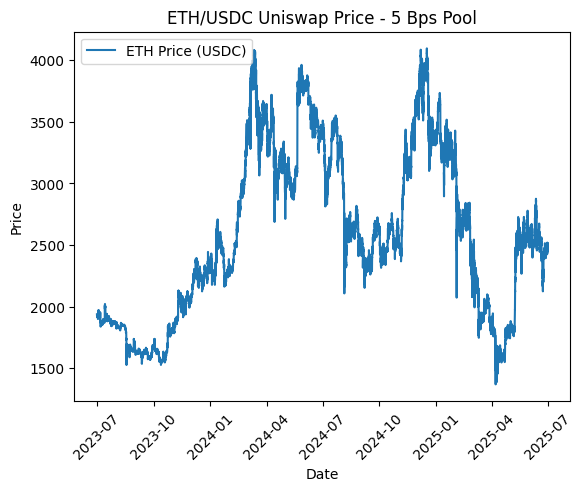

In [21]:
#plot the ETH prices over time
plt.plot(eth_prices, label='ETH Price (USDC)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ETH/USDC Uniswap Price - 5 Bps Pool')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [7]:
# Here if we want to fetch the iv data from uniswap 
uniswap_iv = pool_data.data.iv*100
uniswap_iv = pd.DataFrame(uniswap_iv)
uniswap_iv.to_csv('uniswap_iv_ether.csv')


In [16]:
uniswap_iv_ether = pd.read_csv('uniswap_iv_ether.csv')
uniswap_iv_base = pd.read_csv('uniswap_data_base.csv')

In [17]:
uniswap_iv_base.set_index('block_timestamp', inplace=True)
uniswap_iv_ether.set_index('timestamp', inplace=True)
uniswap_iv_ether.index = pd.to_datetime(uniswap_iv_ether.index)
uniswap_iv_base.index = pd.to_datetime(uniswap_iv_base.index)

In [18]:
uniswap_iv_base

,iv
block_timestamp,
2024-01-01 00:00:05+00:00,NaN
2024-01-01 00:00:29+00:00,NaN
2024-01-01 00:02:07+00:00,NaN
2024-01-01 00:03:55+00:00,NaN
2024-01-01 00:03:55+00:00,NaN
...,...
2025-03-31 23:58:49+00:00,39.500286
2025-03-31 23:59:25+00:00,63.395584
2025-03-31 23:59:27+00:00,63.400756


In [19]:
uniswap_iv_base_hourly = uniswap_iv_base.resample('H').mean()
uniswap_iv_ether_hourly = uniswap_iv_ether.resample('H').mean()

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_50335/2863527495.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  uniswap_iv_base_hourly = uniswap_iv_base.resample('H').mean()
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_50335/2863527495.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  uniswap_iv_ether_hourly = uniswap_iv_ether.resample('H').mean()


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_50335/3150410473.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


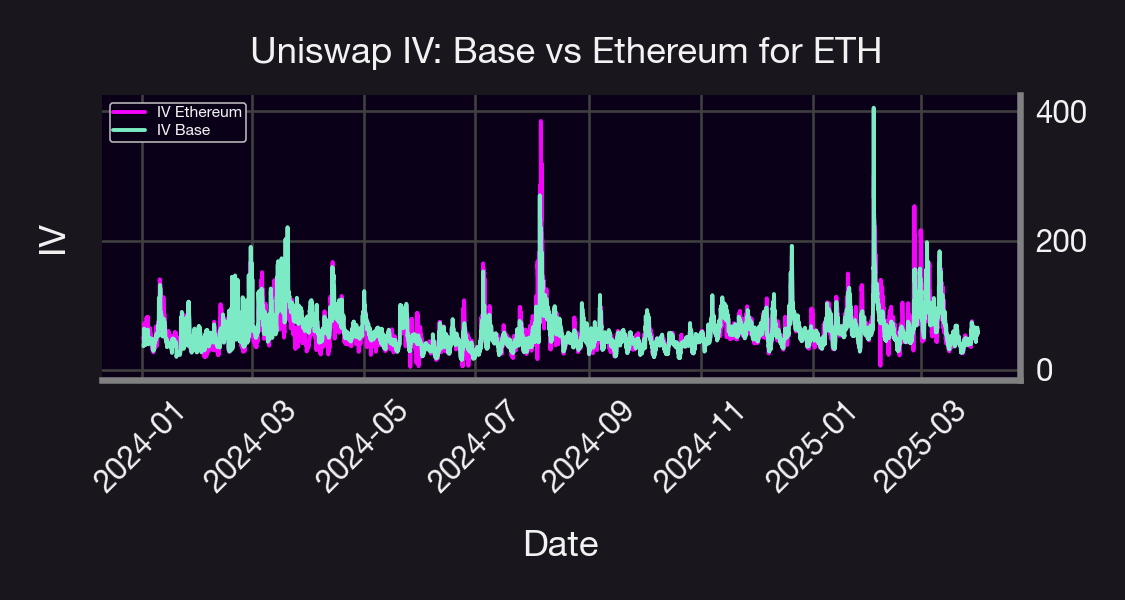

In [20]:
plt.plot(uniswap_iv_ether_hourly.index, uniswap_iv_ether_hourly['iv'], label='IV Ethereum', color='#F305F9')
plt.plot(uniswap_iv_base_hourly.index, uniswap_iv_base_hourly['iv'], label='IV Base', color='#7CEAC5')
plt.xlabel('Date')
plt.ylabel('IV')
plt.title(' Uniswap IV: Base vs Ethereum for ' + chosen_currency)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Align on a common time index
iv_combined = pd.DataFrame({
    'IV_Ethereum': uniswap_iv_ether_hourly['iv'],
    'IV_Base': uniswap_iv_base_hourly['iv']
}).dropna()

# Compute the difference
iv_combined['IV_Diff'] = iv_combined['IV_Base'] - iv_combined['IV_Ethereum']

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gp/T/ipykernel_50335/321964478.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


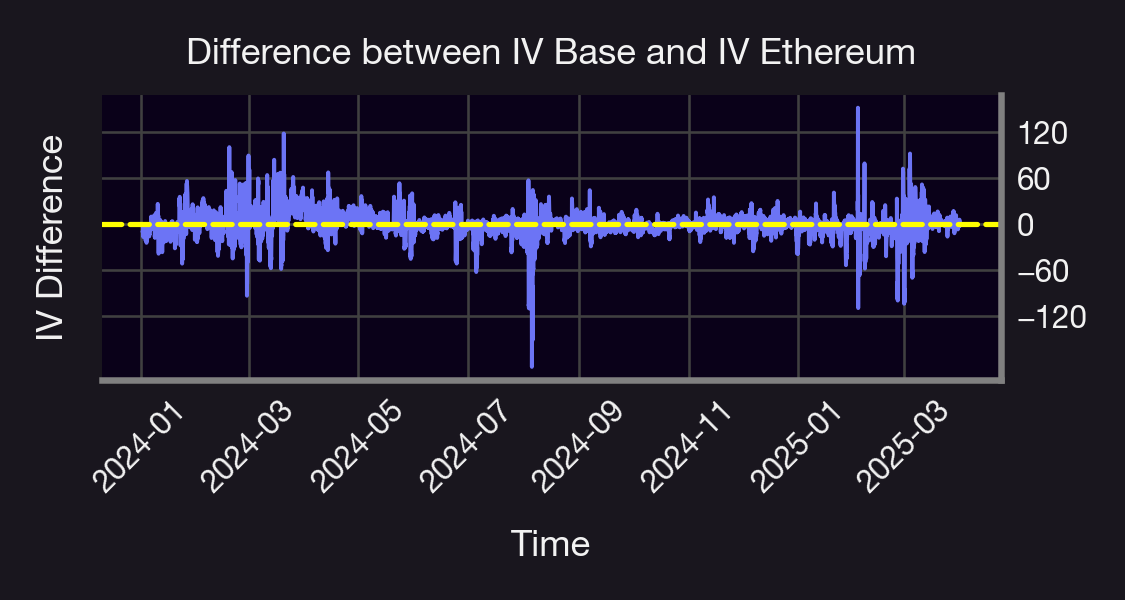

In [22]:
plt.plot(iv_combined.index, iv_combined['IV_Diff'])
plt.axhline(0, color = 'yellow', linestyle='--', linewidth=1)
plt.yticks(np.arange(-120, 150, 60))
plt.title('Difference between IV Base and IV Ethereum')
plt.xlabel('Time')
plt.ylabel('IV Difference')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()